In [ ]:
import pandas as pd
import geopandas as gpd
import folium
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os

In [ ]:
!pip install contextily

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 48.1 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
data_path=('/content/drive/MyDrive/CDS 529 Method/')

df = pd.read_csv(data_path + 'Dataset/Calculate_TPU_index.csv')
df

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


,tpuid,date,Simpson_Index,Simpson_Total,Evenness_Index,Entropy
0,111,2023-09-01 08:00:00,0.559118,165,0.669479,1.338957
1,111,2023-09-01 09:00:00,0.617646,195,0.787274,1.574547
2,111,2023-09-01 10:00:00,0.629341,201,0.808032,1.616064
3,111,2023-09-01 11:00:00,0.604155,190,0.758401,1.516802
4,111,2023-09-01 12:00:00,0.607813,227,0.770307,1.540614
...,...,...,...,...,...,...
68260,976,2023-09-14 17:00:00,0.500000,2,1.000000,1.000000
68261,976,2023-09-14 18:00:00,0.500000,2,1.000000,1.000000
68262,976,2023-09-14 19:00:00,0.000000,1,0.000000,-0.000000
68263,976,2023-09-14 20:00:00,0.000000,1,0.000000,-0.000000


# 指数有效性

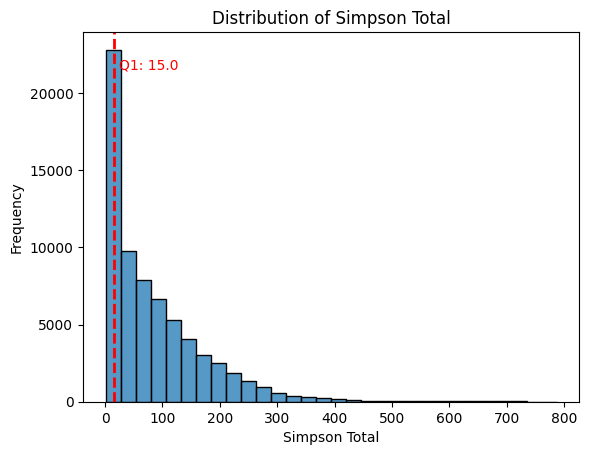

In [ ]:

# 绘制 'Simpson_Total' 的直方图
sns.histplot(df['Simpson_Total'], bins=30, kde=False)  # bins 参数控制直方图的柱数，kde 控制是否显示核密度估计

# 计算第一四分位数
Q1 = df['Simpson_Total'].quantile(0.25)

# 在图上添加第一四分位数的辅助线
plt.axvline(Q1, color='red', linestyle='dashed', linewidth=2)
plt.text(Q1 + 10, plt.ylim()[1]*0.9, f'Q1: {Q1}', color='red')  # 调整位置以避免重叠

# 设置图表的标题和坐标轴标签
plt.title('Distribution of Simpson Total')
plt.xlabel('Simpson Total')
plt.ylabel('Frequency')

# 显示图表
plt.show()

In [ ]:
df_filtered = df[df['Simpson_Total'] >= 15]
df_filtered

,tpuid,date,Simpson_Index,Simpson_Total,Evenness_Index,Entropy
0,111,2023-09-01 08:00:00,0.559118,165,0.669479,1.338957
1,111,2023-09-01 09:00:00,0.617646,195,0.787274,1.574547
2,111,2023-09-01 10:00:00,0.629341,201,0.808032,1.616064
3,111,2023-09-01 11:00:00,0.604155,190,0.758401,1.516802
4,111,2023-09-01 12:00:00,0.607813,227,0.770307,1.540614
...,...,...,...,...,...,...
68038,975,2023-09-15 03:00:00,0.068329,57,0.160499,0.254385
68039,975,2023-09-15 04:00:00,0.141687,53,0.282182,0.447247
68040,975,2023-09-15 05:00:00,0.116618,49,0.245122,0.388509
68041,975,2023-09-15 06:00:00,0.108224,53,0.230789,0.365792


In [ ]:
import tensorflow as tf
gpus = tf.config.list_physical_devices("GPU")

if gpus:
    gpu0 = gpus[0] #如果有多个GPU，仅使用第0个GPU
    tf.config.experimental.set_memory_growth(gpu0, True) #设置GPU显存用量按需使用
    tf.config.set_visible_devices([gpu0],"GPU")


In [ ]:
# TPU 读取
gfs = []
for f in os.listdir(data_path+ '/tpu_data_geo/'):
    if 'shp' not in f:
        continue
    if '._' in f:
        continue
    ## GBK for encode Chinese
    shapefile = gpd.read_file( data_path + '/tpu_data_geo/%s' % f, encoding="GBK")
    tupid = f.split('_')[1].split('.')[0]
    shapefile['tpuid'] = tupid
    ## set crs
    shapefile.crs = 'EPSG:4326'
    gfs.append(shapefile)
gfs = gpd.GeoDataFrame(pd.concat(gfs))

## select two columns only
sel_cols = ['tpuid', 'geometry']
gfs_sel = gfs[sel_cols]


# 筛选出1-5点的夜间隔离指数

In [ ]:
df_filtered['date'] = pd.to_datetime(df_filtered['date'])

df_filtered['hour'] = df_filtered['date'].dt.hour

# 筛选出凌晨1点到5点之间的结果
filtered_df = df_filtered[(df_filtered['hour'] >= 1) & (df_filtered['hour'] < 5)]

filtered_df

<ipython-input-10-d9e621012031>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['date'] = pd.to_datetime(df_filtered['date'])
<ipython-input-10-d9e621012031>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['hour'] = df_filtered['date'].dt.hour


,tpuid,date,Simpson_Index,Simpson_Total,Evenness_Index,Entropy,hour
17,111,2023-09-02 01:00:00,0.551865,219,0.661171,1.322343,1
18,111,2023-09-02 02:00:00,0.548223,197,0.647836,1.295671,2
19,111,2023-09-02 03:00:00,0.533736,196,0.615237,1.230474,3
20,111,2023-09-02 04:00:00,0.534085,169,0.628091,1.256183,4
41,111,2023-09-03 01:00:00,0.542652,187,0.631396,1.262792,1
...,...,...,...,...,...,...,...
68015,975,2023-09-14 04:00:00,0.270552,31,0.637387,0.637387,4
68036,975,2023-09-15 01:00:00,0.139898,67,0.275611,0.436833,1
68037,975,2023-09-15 02:00:00,0.072016,54,0.167559,0.265575,2
68038,975,2023-09-15 03:00:00,0.068329,57,0.160499,0.254385,3


# 按天计算每天夜晚的均值

In [ ]:
# 将日期列转换为日期类型
filtered_df['date'] = pd.to_datetime(filtered_df['date']).dt.date

# 根据每天的Simpson_Index计算均值
night_mean = filtered_df.groupby(['tpuid', 'date'])['Simpson_Index'].mean().reset_index()
night_mean

<ipython-input-11-3311301f92f6>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['date'] = pd.to_datetime(filtered_df['date']).dt.date


,tpuid,date,Simpson_Index
0,111,2023-09-02,0.541977
1,111,2023-09-03,0.543233
2,111,2023-09-04,0.528317
3,111,2023-09-05,0.530890
4,111,2023-09-06,0.511964
...,...,...,...
1917,975,2023-09-11,0.091737
1918,975,2023-09-12,0.096328
1919,975,2023-09-13,0.128298
1920,975,2023-09-14,0.270016


# 计算每个Tpu 15天夜晚的Simpson指数均值（baseline ）

In [ ]:
tpu_mean = night_mean .groupby('tpuid')['Simpson_Index'].mean().reset_index()

tpu_mean

,tpuid,Simpson_Index
0,111,0.538805
1,112,0.601223
2,113,0.524133
3,114,0.212765
4,115,0.461967
...,...,...
140,838,0.416965
141,839,0.452547
142,950S,0.495525
143,971S,0.319769


In [ ]:
# 将计算结果与地理数据合并
Night_df = pd.merge(tpu_mean , gfs_sel, on='tpuid', how='right')

# 将结果转换为 GeoDataFrame 并设置坐标参考系统
Night_df = gpd.GeoDataFrame(Night_df, geometry='geometry')
Night_df.crs = "EPSG:4326"

Night_df

,tpuid,Simpson_Index,geometry
0,976,NaN,"MULTIPOLYGON (((114.04660 22.28246, 114.04659 ..."
1,757,0.508104,"POLYGON ((114.22675 22.40193, 114.22674 22.401..."
2,975,0.114736,"MULTIPOLYGON (((114.06239 22.34132, 114.06240 ..."
3,758,0.179154,"POLYGON ((114.19339 22.38160, 114.19021 22.378..."
4,822,NaN,"POLYGON ((114.26448 22.38258, 114.26434 22.382..."
...,...,...,...
209,932S,NaN,"MULTIPOLYGON (((113.92237 22.15340, 113.92236 ..."
210,941S,NaN,"MULTIPOLYGON (((113.83562 22.21772, 113.83563 ..."
211,950S,0.495525,"MULTIPOLYGON (((113.97876 22.32745, 113.97876 ..."
212,961S,NaN,"MULTIPOLYGON (((114.00320 22.26172, 114.00317 ..."


<Axes: >

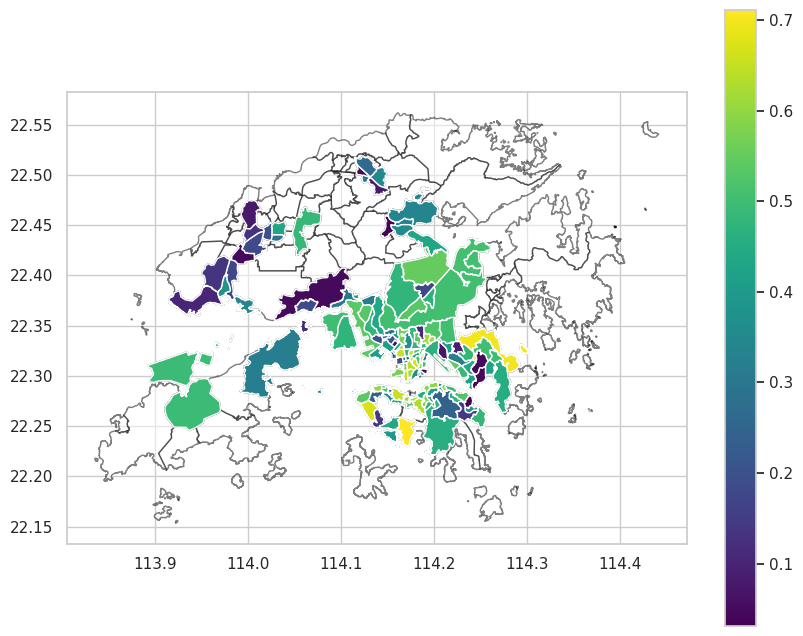

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
ax = gfs_sel.plot(ax=ax, alpha=0.5, color="white", edgecolor="black")
Night_df.plot(ax=ax, column="Simpson_Index", cmap='viridis', legend=True)

In [ ]:
center = [22.3193, 114.1694]
m = folium.Map(location=center, zoom_start=12)

import branca

colormap_tpu = branca.colormap.LinearColormap(
    vmin=Night_df['Simpson_Index'].min(), vmax=Night_df['Simpson_Index'].max(),
    colors=['darkblue', 'blue', 'red', 'darkred'],
    caption="Change Index",
)

tooltip = folium.GeoJsonTooltip(
    fields=["Simpson_Index"],
    aliases=["Simpson_Index"],
    localize=True,
    sticky=False,
    labels=True,
    style="""
        background-color: #F0EFEF;
        border: 2px solid black;
        border-radius: 3px;
        box-shadow: 3px;
    """,
    max_width=800,
)

g = folium.GeoJson(
    Night_df,
    style_function=lambda x: {
        "fillColor": colormap_tpu(x["properties"]["Simpson_Index"]) if x["properties"]["Simpson_Index"] is not None else "white",
        "color": "black",
        "fillOpacity": 0.4,
    },
    tooltip=tooltip,
).add_to(m)

colormap_tpu.add_to(m)

m


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
#m.save(data_path+"Simpson_Index.html")

# 相关性分析（为什么有的地区高有的地区低）

In [ ]:
Tpu_df = pd.read_csv(data_path + 'Dataset/TPU.csv',encoding="utf-8")
# 将列名修改为"tpuid"
Tpu_df = Tpu_df.rename(columns={"小規劃統計區－小合併組": "tpuid"})

In [ ]:
merged_df = Night_df.merge(Tpu_df, on='tpuid')
merged_df

,tpuid,Simpson_Index,geometry,Unnamed: 0,小規劃統計區－小合併組（英文名稱),小規劃統計區－小合併組（中文名稱),總人口,男性,女性,性別比率（即男性數目與每千名女性相對的比率）,...,金融保险服务,体育休闲服务,科教文化服务,医疗保健服务,生活服务,餐饮服务,商务住宅,交通设施服务,购物服务,公司企业
0,976,NaN,"MULTIPOLYGON (((114.04660 22.28246, 114.04659 ...",213,976,976,5480,2507,2973,843,...,3,11,4,7,4,47,8,5,18,12
1,757,0.508104,"POLYGON ((114.22675 22.40193, 114.22674 22.401...",183,757,757,209714,97342,112372,866,...,60,62,152,185,223,410,142,216,550,214
2,975,0.114736,"MULTIPOLYGON (((114.06239 22.34132, 114.06240 ...",212,975,975,15012,6637,8375,792,...,0,5,4,2,4,38,3,5,9,9
3,758,0.179154,"POLYGON ((114.19339 22.38160, 114.19021 22.378...",184,758,758,48544,21531,27013,797,...,7,8,20,31,24,44,42,32,145,144
4,822,NaN,"POLYGON ((114.26448 22.38258, 114.26434 22.382...",189,822,822,6257,2726,3531,772,...,0,1,0,0,2,1,6,8,4,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
209,932S,NaN,"MULTIPOLYGON (((113.92237 22.15340, 113.92236 ...",206,932 and 934,932 及 934,2526,1460,1066,1370,...,0,2,0,0,0,4,0,6,3,2
210,941S,NaN,"MULTIPOLYGON (((113.83562 22.21772, 113.83563 ...",207,941 - 943,941 - 943,1184,877,307,2857,...,1,12,4,8,5,39,19,35,35,12
211,950S,0.495525,"MULTIPOLYGON (((113.97876 22.32745, 113.97876 ...",209,950 - 951,950 - 951,86403,40062,46341,865,...,24,20,38,52,56,192,61,139,213,62
212,961S,NaN,"MULTIPOLYGON (((114.00320 22.26172, 114.00317 ...",210,961 - 963,961 - 963,7403,3920,3483,1125,...,1,15,12,6,12,43,20,20,34,19


# 计算人口密度

In [ ]:
# 转换CRS到香港投影坐标系统，而不是之前4326的地理坐标系统
merged_df = merged_df.to_crs(epsg=2326)

In [ ]:
# 计算面积，单位为平方米
merged_df['area'] = merged_df.area

# 计算人口密度（人/平方米）
merged_df['population_density'] = merged_df['總人口'] / merged_df['area']

# 将面积转换为平方千米
merged_df['area_km2'] = merged_df['area'] / 1e6

# 计算人口密度（人/平方千米）
merged_df['population_density_per_km2'] = merged_df['總人口'] / merged_df['area_km2']


# 计算与隔离指数相关的前十特征

In [ ]:
# 选择只包含数值类型数据的列
numeric_columns = merged_df.select_dtypes(include=[np.number]).columns
subset_df = merged_df[numeric_columns]

# 计算特征之间的相关性
correlation_matrix = subset_df.corr()

# 获取与"Simpson_Index"指标的相关性，并选择前十个特征
top_correlated_features = correlation_matrix['Simpson_Index'].sort_values(ascending=False)[1:13]

print("Top 10 Features Correlated with Simpson Index:")
for feature, score in top_correlated_features.items():
    print(f"{feature}: {score:.2f}")

Top 10 Features Correlated with Simpson Index:
count_off: 0.30
count_on: 0.27
政府机构及社会团体: 0.27
购物服务: 0.26
住宿服务: 0.24
体育休闲服务: 0.23
医疗保健服务: 0.23
生活服务: 0.23
餐饮服务: 0.23
通行设施: 0.22
科教文化服务: 0.21
金融保险服务: 0.21


In [ ]:
!wget -O simhei.ttf "https://www.wfonts.com/download/data/2014/06/01/simhei/chinese.simhei.ttf"

--2024-05-02 11:41:08--  https://www.wfonts.com/download/data/2014/06/01/simhei/chinese.simhei.ttf
Resolving www.wfonts.com (www.wfonts.com)... 172.67.129.58, 104.21.1.127, 2606:4700:3031::ac43:813a, ...
Connecting to www.wfonts.com (www.wfonts.com)|172.67.129.58|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10050870 (9.6M) [application/octetstream]
Saving to: ‘simhei.ttf’

simhei.ttf          100%[===================>]   9.58M  14.8MB/s    in 0.6s    

2024-05-02 11:41:09 (14.8 MB/s) - ‘simhei.ttf’ saved [10050870/10050870]



In [ ]:
import matplotlib
import matplotlib.font_manager as font_manager

matplotlib.font_manager.fontManager.addfont('simhei.ttf')
matplotlib.rc('font', family='SimHei')


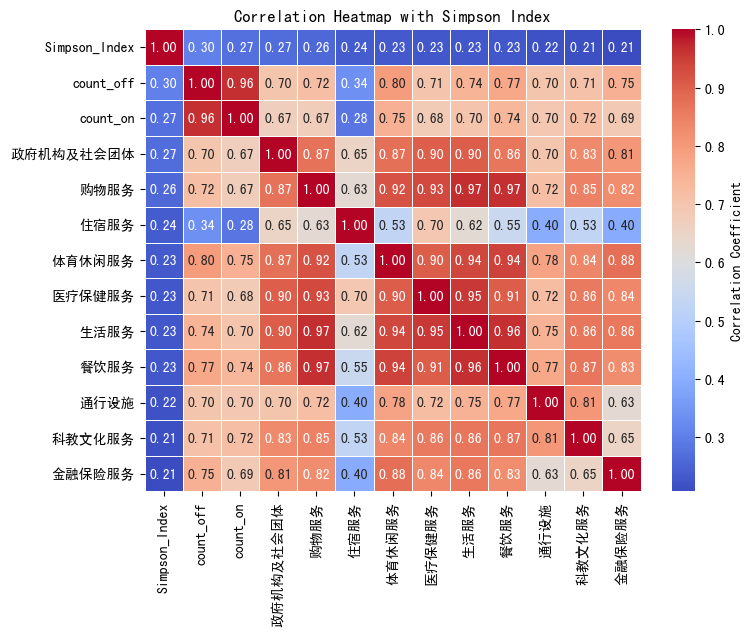

In [ ]:
# 生成热力图的相关性子矩阵
top_features = ['Simpson_Index'] + list(top_correlated_features.index)
correlation_submatrix = correlation_matrix.loc[top_features, top_features]

# 绘制热力图
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_submatrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, cbar_kws={'label': 'Correlation Coefficient'})
plt.title('Correlation Heatmap with Simpson Index')
plt.show()

# 三维散点图（3 feature）

In [28]:
scatter_df = pd.merge(Night_df, merged_df[['tpuid', 'population_density','政府机构及社会团体']], on='tpuid', how='left')
scatter_df

,tpuid,Simpson_Index,geometry,population_density,政府机构及社会团体
0,976,NaN,"MULTIPOLYGON (((114.04660 22.28246, 114.04659 ...",0.005508,5
1,757,0.508104,"POLYGON ((114.22675 22.40193, 114.22674 22.401...",0.025865,47
2,975,0.114736,"MULTIPOLYGON (((114.06239 22.34132, 114.06240 ...",0.014565,3
3,758,0.179154,"POLYGON ((114.19339 22.38160, 114.19021 22.378...",0.021732,28
4,822,NaN,"POLYGON ((114.26448 22.38258, 114.26434 22.382...",0.001368,0
...,...,...,...,...,...
209,932S,NaN,"MULTIPOLYGON (((113.92237 22.15340, 113.92236 ...",0.000190,0
210,941S,NaN,"MULTIPOLYGON (((113.83562 22.21772, 113.83563 ...",0.000026,4
211,950S,0.495525,"MULTIPOLYGON (((113.97876 22.32745, 113.97876 ...",0.002372,54
212,961S,NaN,"MULTIPOLYGON (((114.00320 22.26172, 114.00317 ...",0.000307,18


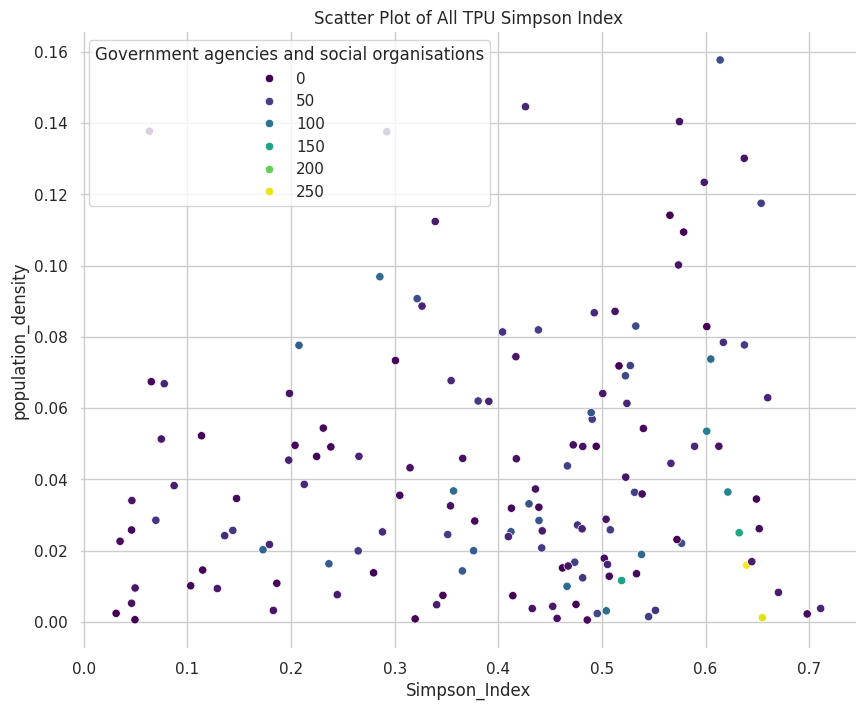

In [31]:
# 设置绘图风格
sns.set_theme(style="whitegrid")

# 创建一个图形和轴对象
f, ax = plt.subplots(figsize=(10, 8))
sns.despine(f, left=True, bottom=True)

# 绘制散点图
scatter_plot = sns.scatterplot(
    x="Simpson_Index",
    y="population_density",
    hue="政府机构及社会团体",  # 使用人口密度作为颜色
    palette="viridis",         # 使用viridis颜色映射
    data=scatter_df,
    ax=ax
)

# 设置轴标签和标题
ax.set_xlabel("Simpson_Index")
ax.set_ylabel("population_density")
ax.set_title("Scatter Plot of All TPU Simpson Index")

# 显示颜色图例
scatter_plot.legend(title='Government agencies and social organisations')

# 显示图形
plt.show()